# Data Preparation for Imbalanced Data: Credit Card Fraud Detection

**TL;DR** This notebook evaluates the performance of a simple Logistic Regression on the imbalanced Credit Card Fraud data from kaggle. The focus lies on the data preparation: **Autoencoder, Oversampling (SMOTE), Random Under-sampling and a Combined Sampling method** are used to transform the data before applying the model. Because it is a common mistake to apply data transformations in a way that leads to data leakage, this topic is also covered. In general, classification on sampled datasets achieves higher accuracy in classifying fraudulent transactions while it gets more normal transactions wrong, whereas the Logistic Regression on the latent data from the Autoencoder seems to be a more balanced approach, achieving the highest average precision.

## Introduction

- **Context:** In order to enhance security, credit card companies would like to detect fraudulent transactions. Machine Learning can help with this.
- **Limitations:** It is relatively simple to increase the number of correctly classified fraudulent transactions at the cost of misclassifying normal transactions. Weighing the economic costs of misclassifying normal and fraudulent transactions and therefore identifying the best result is beyond the scope of the analysis. 

### Description of the Dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. (Source: [kaggle.com/mlg-ulb/creditcardfraud](https://www.kaggle.com/mlg-ulb/creditcardfraud))

### Approach

A Logistic Regression will be performed after applying different techniques for dealing with the imbalance in the data set. A couple of options have been considered for dealing with the imbalance problem and the following five are implemented now:

1. **Logistic Regression:** this will show the performance on the imbalanced data and serves as a baseline for further comparison.
2. **Autoencoder:** used to extract a latent representation of the training data. Compression of the data might improve the inherent information.
3. **Over-sample the data:** over-sampling will yield balanced classes but with a lot of data that makes training computationally expensive.
4. **Under-sample the data:** under-sampling will yield balanced classes but with the cost of loss of information.
5. **Combined Sampling:** use SMOTE and Tomek links to combine both over- and under-sampling techniques.

### Evaluation Metric

As proposed by the provider of this dataset the **Area Under the Precision-Recall Curve (AUPRC)** is used for performance evaluation because confusion matrix accuracy is not meaningful for unbalanced classification. 

## Prerequisites

### Import Packages

In [2]:
import json
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('precision', 2)

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
                             plot_precision_recall_curve)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tqdm.keras import TqdmCallback
tf.random.set_seed(42)
print(tf.__version__)

2.1.0


### Set Global Variables

In [3]:
seed = 1
accuracy = 'average_precision' # equals to area under recall precision curve
lr_max_iterations = 10000 # increased max_iter to allow lbfgs-solver converging
results = []

## Data Preparation

### Import Data
The dataset exceeds Githubs allowed file-size limits and is therefore only available in .zip format. The helper-function *load_data()* allows data loading independent from whether the archive is already unpacked or not.

In [4]:
def load_data():
    """ Unzip archive if necessary, import the data and return a Dataframe """
    
    data_dir = Path.cwd() / 'data'  
    csv_file = Path(data_dir/'creditcard.csv')
    zip_file = Path(data_dir/'creditcard.zip')
    
    if not csv_file.exists() and zip_file.exists():
        with zipfile.ZipFile(zip_file,"r") as zip_ref:
            zip_ref.extractall(data_dir)        
        
    return pd.read_csv(csv_file)

In [5]:
df = load_data()

assert(df.shape[0] == 284807) # let's make sure the data is loaded as expected
assert(df.shape[1] == 31)

### Split into Train and Test Set
For splitting we use sklearns *train_test_split* with the stratify option in order to keep the ratio of normal and fraudulent transactions in the test and training data equal.

In [6]:
X_orig = df.drop('Class', axis=1)
y_orig = df.Class

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2,
                                                    random_state=seed, stratify=y_orig)
test_data = [X_test, y_test]

In [7]:
print(f"Training data class counts:\n{y_train.value_counts()}")
print('')
print(f"Test data class counts:\n{y_test.value_counts()}")
print('')
assert(y_test.shape[0]/y_orig.shape[0] > 0.19)

Training data class counts:
0    227451
1       394
Name: Class, dtype: int64

Test data class counts:
0    56864
1       98
Name: Class, dtype: int64



### Standardizing (and avoiding Data Leakage)
The dataset contains two features ('Amount' and 'Time') that are on a totally different scale than the rest of the features. who are the result of a Principal Component Analysis). In theory it isn't required to standardize data for Logistic Regression (e.g. [here](https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression)). Nonetheless, tests have shown better performance of Logistic Regression when the data has been standardized in advance and because of that the data here will be scaled.

However, we did not scale the data before the split. In order to avoid information from the training data [leaking](https://machinelearningmastery.com/data-leakage-machine-learning/) into the test-set, this is done afterwards. Data Scientists far too often neglect the effects of data leakage, scaling their whole dataset before the model training. This may improve the models performance in an unwanted manner and result in worse accuracy when dealing with data in production. 

Here is a simple "recipe" for standardization:
 - Create the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) object
 - Fit scaler on the training data and transform the data
 - Transform the test data without fitting the scaler again

In [8]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_data_scaled = [X_test_scaled, y_test]

## Logistic Regression Baseline
Let us create a simple Logistic Regression model to see how things go. We will not compare multiple models but rather focus on dealing with the imbalance in this dataset. To estimate the models performance we use [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) because it equals the Area Under the Precision-Recall Curve.

In [9]:
def evaluate_model(test_data, estimator, name='Not specified'):
    
    X_test = test_data[0]
    y_test = test_data[1]
    
    num_fraud_cases_in_test = len(y_test[y_test==1])
    num_normal_cases_in_test = len(y_test[y_test==0])
    
    predictions = estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Plot normalized confusion matrix and precision recall curve
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    
    plot_confusion_matrix(estimator, X_test, y_test, normalize='true',
                          display_labels=['Normal', 'Fraud'], cmap='Greens', values_format=".4f", ax=axes[0])
    axes[0].set_title('Confusion Matrix (normalized)')
    
    prc = plot_precision_recall_curve(estimator, X_test, y_test, name=name, ax=axes[1])
    axes[1].set_title('Precision Recall Curve')
    plt.tight_layout()
    
    # Print summary    
    print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
    print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
    print(f"Average preicision score is {prc.average_precision:.4f}")
    
    return [name, cm[1,1], cm[1,1]/num_fraud_cases_in_test*100, cm[0,1], prc.average_precision]

Classified 	69 out of 98 	fraud cases correctly
Misclassified 	10 out of 56864 normal cases
Average preicision score is 0.8136


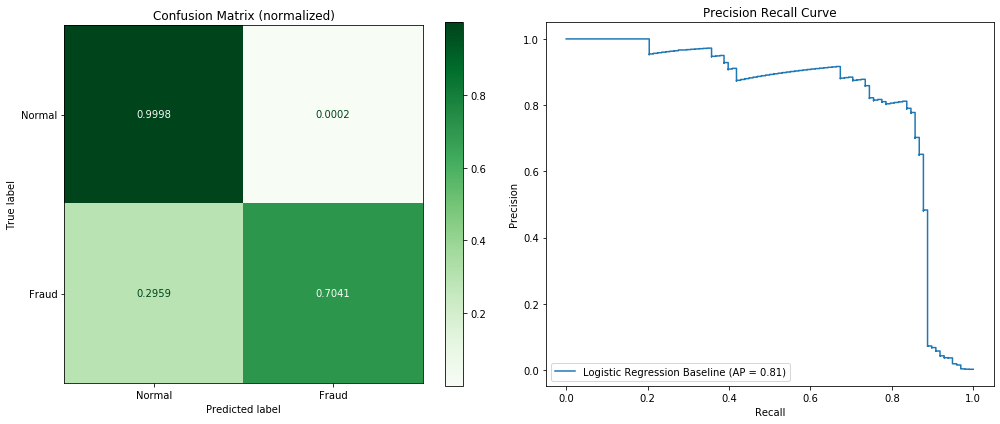

In [10]:
simple_LR = LogisticRegression(max_iter=lr_max_iterations, random_state=seed) 
simple_LR.fit(X_train_scaled, y_train)
res = evaluate_model(test_data_scaled, simple_LR, name='Logistic Regression Baseline')
results.append(res)

The baseline model does not perform too bad. It already identifies 70% of frauds and classifies 99,98% of normal transactions correctly. The area under the precision-recall-curve or average precision is 0.8136.

## Autoencoder

### Prepare Data for Autoencoder
For training the Autoencoder only needs samples of the majority class because it is supposed to learn a compressed representation of those. Therefore the training data set is separated by class and a fraction of the normal samples are used for the Autoencoder training. To improve convergence they are standardized as well.
The samples showed to the Autoencoder should not be used to train the Logistic Regression model. Therefore, a new training set for the estimator is created.

In [11]:
X_train_0 = X_train[y_train == 0]
X_train_AE = X_train_0.sample(frac=0.5, random_state=seed)
X_train_AE_scaled = StandardScaler().fit_transform(X_train_AE)

X_train_est = X_train.drop(X_train_AE.index)
y_train_est = y_train.drop(X_train_AE.index)

latent_scaler = StandardScaler()
X_train_est_scaled = latent_scaler.fit_transform(X_train_est)
X_test_est_scaled = latent_scaler.transform(X_test)

### Autoencoder Model
The Autoencoder consists of 5 layers: an input layer and the encoding part, the latent representation itself and the decoder part as well as an output layer. It is up to discussion what fraction of the data should be used for Autoencoder training and respectively kept for the Linear Regression. Furthermore, no optimization has been performed on this model. As we will see later, it has a nice and converging training curve and does the job.

In [12]:
def create_autoencoder(input_dim=30, latent_dim=50):
    """ Creates an Autoencoder Model where input_dim is the number of features.
    The encoding part uses L1-regularization as sparsity constraint """
    
    input_layer = Input(shape=(input_dim,), name='Input')
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name='Encoding')(input_layer)
    latent =  Dense(latent_dim, activation='relu', name='Latent')(encoded)
    decoded = Dense(100, activation='relu', name='Decoding')(latent)
    output_layer = Dense(input_dim, activation='linear', name='Output')(decoded)
    
    autoencoder = Model(input_layer, output_layer)
    return autoencoder

In [ ]:
autoencoder = create_autoencoder()
autoencoder.compile(optimizer="adadelta", loss="mse")
autoencoder.summary()
    
history = autoencoder.fit(X_train_AE_scaled, X_train_AE_scaled,
                          batch_size=64, epochs=500, verbose=0, validation_split=0.15,
                          callbacks=[TqdmCallback(), EarlyStopping(patience=3)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 30)]              0         
_________________________________________________________________
Encoding (Dense)             (None, 100)               3100      
_________________________________________________________________
Latent (Dense)               (None, 50)                5050      
_________________________________________________________________
Decoding (Dense)             (None, 100)               5100      
_________________________________________________________________
Output (Dense)               (None, 30)                3030      
Total params: 16,280
Trainable params: 16,280
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.title("Autoencoder Training History")
plt.show()

### Encoder Model and Latent Representation
The encoder part of the Autoencoder consists of all the layers from the input layer up to the latent layer, which in this case are the first three layers. By predicting the compressed representation of the data one can easily extract the latent data for classification.

In [ ]:
def create_encoder(autoencoder):
    encoder = Sequential([autoencoder.layers[0],
                          autoencoder.layers[1],
                          autoencoder.layers[2]])
    return encoder

In [ ]:
encoder = create_encoder(autoencoder)
encoder.summary()

In [ ]:
X_train_latent = encoder.predict(X_train_est_scaled)
X_test_latent = encoder.predict(X_test_est_scaled)
test_data_latent = [X_test_latent, y_test]

### Classification
Now that the latent representation has been extracted the data can be classified, again using a Linear Regression model. This time the model will be optimized using 5-fold cross-validation.

In [ ]:
log_reg_cv = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)
log_reg_cv.fit(X_train_latent, y_train_est)
res = evaluate_model(test_data_latent, log_reg_cv, name='Autoencoder')
results.append(res)

Classifying on the latent representations leads to an improvement of ~9% points for the fraudulent transactions. A few more normal transactions have been misclassified but it is almost negligible. The average precision is now 0.8271, so only a little bit better than the baseline.

## Sampling Methods
By sampling we understand the draw of an example - in this case a credit card transaction - from the distribution of known examples. In case of SMOTE (oversampling) this is more or less what happens. Most under-sampling methods on the other hand remove examples of the majority class, reducing it to the number of examples in the minority class. These methods can also be combined.

One important thing when using sampling methods combined with cross-validation is to avoid data leakage. In order to do this, it is essential to sample during cross-validation and not before. Luckily the imbalanced-learn package provides us with a pipeline that takes care of exactly that. The picture below shows the framework that is applied here.

![A framework for using sampling methods with cross-validation](img/sampling-framework.PNG "Logo Title Text 1")



All the sampling methods are from the [imbalanced-learn](https://imbalanced-learn.org/stable/index.html) package.

### Oversampling

Classified 	90 out of 98 	fraud cases correctly
Misclassified 	532 out of 56864 normal cases
Average preicision score is 0.8046


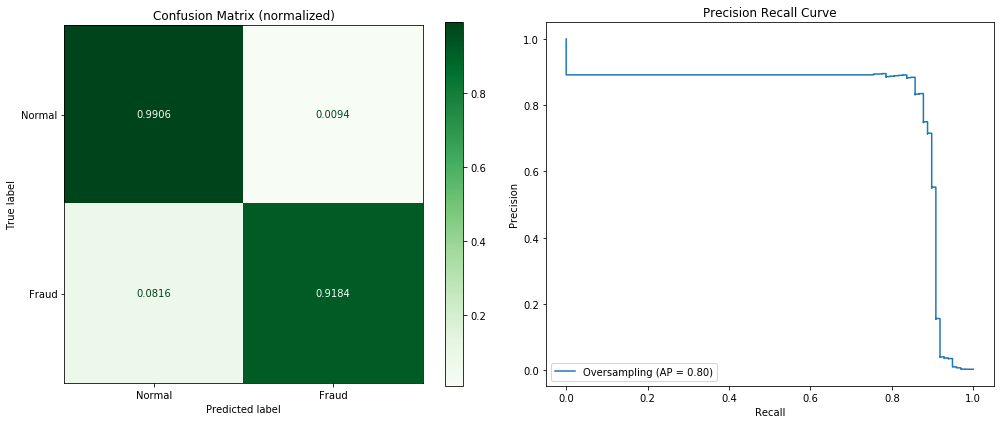

In [97]:
oversampler = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=seed)
log_reg_os  = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

pipeline = imbPipeline([
    ('sampler', oversampler),
    ('transformer', StandardScaler()),
    ('classification', log_reg_os)])

pipeline.fit(X_train, y_train)

res = evaluate_model(test_data, pipeline, name='Oversampling')
results.append(res)

With oversampling the model identifies almost 92% of the fraudulent transactions correctly. On the downside almost 1% of the normal cases are misclassified. The average precision dropped 0.8046, the worst so far.

### Undersampling

Classified 	91 out of 98 	fraud cases correctly
Misclassified 	1389 out of 56864 normal cases
Average preicision score is 0.6490


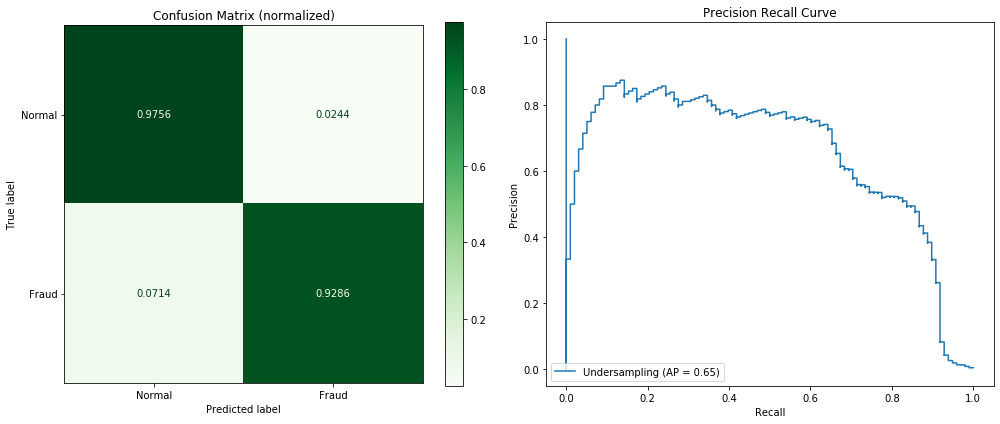

In [98]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
log_reg_us   = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

pipeline = imbPipeline([
        ('sampler', undersampler),
        ('transformer', StandardScaler()),
        ('estimator', log_reg_us)])

pipeline.fit(X_train, y_train)

res = evaluate_model(test_data, pipeline, 'Undersampling')
results.append(res)

Applying the model to the under-sampled data detects one more fraud case than with oversampling, the score now being at almost 93%. But the increase in misclassified normal transactions is huge with around 7% leading to a decrease in average precision to merely 0.6490.

### Combinded Sampling

Classified 	90 out of 98 	fraud cases correctly
Misclassified 	531 out of 56864 normal cases
Average preicision score is 0.8047


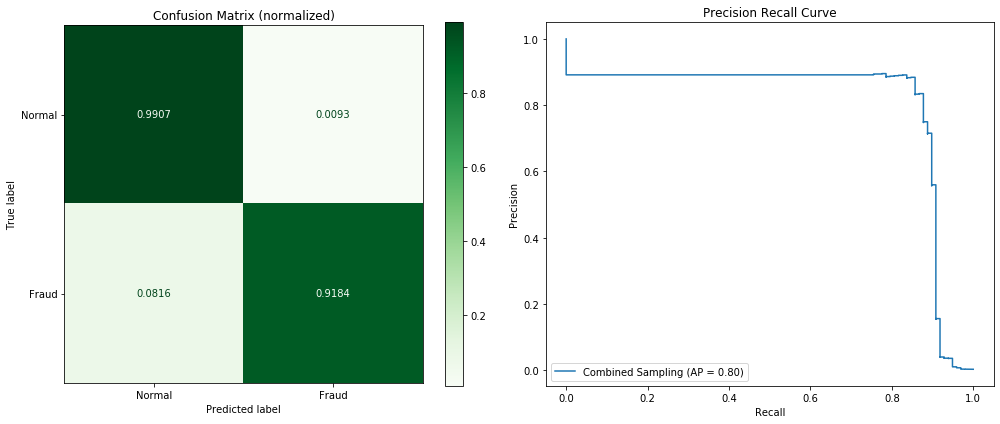

In [99]:
combined_sampler = SMOTETomek(n_jobs=-1, random_state=seed)
log_reg_comb   = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

pipeline = imbPipeline([
        ('sampler', combined_sampler),
        ('transformer', StandardScaler()),
        ('estimator', log_reg_comb)])

pipeline.fit(X_train, y_train)

res = evaluate_model(test_data, pipeline, 'Combined Sampling')
results.append(res)

Combined sampling yields almost the same results as oversampling. It performs slightly better, classifying one additional normal case correctly. The change in average precision is minor with now 0.8047.

## Conclusion
To compare the results we can convert the list of results to a DataFrame:

In [101]:
pd.DataFrame(results,
             columns=["Model", "True Negatives (TN)", "TN in %", "False Positives (FP)", "AUPRC"]
            ).set_index("Model")

,True Negatives (TN),TN in %,False Positives (FP),AUPRC
Model,,,,
Logistic Regression Baseline,69,70.41,10,0.81
Autoencoder,77,78.57,14,0.83
Oversampling,90,91.84,532,0.80
Undersampling,91,92.86,1389,0.65
Combined Sampling,90,91.84,531,0.80


It is noticeable that the classifier seems to identify fraudulent transactions way easier when sampling methods have been applied (69-77 TN vs. 90-91 TN) but on the other hand it gets a lot more normal transactions wrong (10-14 FP vs 531-1389 FP).

Looking at the Area Under the Precision-Recall Curve, all sampling models are worse than the baseline (0.65 and 0.80 < 0.81) whereas the Autoencoder clearly has the best score with 0.83. All in all, the Autoencoder seems to be the most balanced approach to tackle this problem and can certainly be optimized.